In [1]:
import mne
import pybv
import mne_bids
import os
import numpy as np
from matplotlib import pyplot as plt
import scipy

requirements for a function to write BIDS: 
1. data 
2. channel names (maybe wrapper for those channel names)
3. BIDS specifications: (BIDS_path, subject_id, session, task, run)
    
 - BIDS need to be written into brainvision! 


 save raw file since spm files 
 1. cannot be read in python 
 2. .dat files are read as raw_byte streams (not in array shapes) 
 3. there exists no spm eeg python reader, and the file_array type in 
 Matlab is of SPM type 

### read .mat struct files

In [2]:
#from https://stackoverflow.com/questions/7008608/scipy-io-loadmat-nested-structures-i-e-dictionaries
import scipy.io as spio

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

In [11]:
def write_my_BIDS(ch_labels, fsample, ieegdata, subject_id, session, task, run, BIDS_path):
    info = mne.create_info(ch_labels, fsample, ch_types='ecog')
    raw = mne.io.RawArray(ieegdata, info)
    raw.set_eeg_reference(ref_channels=[]) # idea to set this writing out BIDS with rereference field 

    #bids_basename = mne_bids.make_bids_basename(subject=subject_id, session=session, \
    #                                            task=task, run=run)
    bids_basename = mne_bids.BIDSPath(subject=subject_id, session=session, \
                                                task=task, run=run, root=BIDS_path)
    pybv.write_brainvision(ieegdata, fsample, ch_labels, 'dummy_write', os.getcwd())

    bv_raw = mne.io.read_raw_brainvision('dummy_write.vhdr')

    # set all channel types to ECOG for iEEG - BIDS does not allow more than one channel type
    mapping = {}
    for ch in range(len(bv_raw.info['ch_names'])):
        mapping[bv_raw.info['ch_names'][ch]] = 'ecog'
    bv_raw.set_channel_types(mapping)

    bv_raw.info['line_freq'] = 50
    mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)

    #  remove dummy file
    os.remove('dummy_write.vhdr')
    os.remove('dummy_write.eeg')
    os.remove('dummy_write.vmrk')

### sub004

#### BIDS_save_493ov64_rotameterbrady_on_ref_stnr10010010001

In [4]:
dat = loadmat("sub004\\AO\\BIDS_save_rest_ao_5min0001")

In [5]:
list(dat["BIDS_struct_save"]["labels"])

['CECOG_LF_1___01___STNR___01',
 'CECOG_LF_1___02___STNR___02',
 'CECOG_LF_1___03___STNR___03',
 'CECOG_LF_1___04___STNR___04',
 'CECOG_LF_1___05___STNR___05',
 'CECOG_LF_1___06___STNR___06',
 'CECOG_LF_1___07___STNR___07',
 'CECOG_LF_1___08___STNR___08',
 'CECOG_LF_1___09___STNL___01',
 'CECOG_LF_1___10___STNL___02',
 'CECOG_LF_1___11___STNL___03',
 'CECOG_LF_1___12___STNL___04',
 'CECOG_LF_1___13___STNL___05',
 'CECOG_LF_1___14___STNL___06',
 'CECOG_LF_1___15___STNL___07',
 'CECOG_LF_1___16___STNL___08',
 'CECOG_LF_2___01___ECOG___01',
 'CECOG_LF_2___02___ECOG___02',
 'CECOG_LF_2___03___ECOG___03',
 'CECOG_LF_2___04___ECOG___04',
 'CECOG_LF_2___05___ECOG___05',
 'CECOG_LF_2___06___ECOG___06',
 'CECOG_LF_2___07___EEG___01',
 'CECOG_LF_2___08___EEG___02',
 'CEMG_3___01___right_hand',
 'CEMG_3___02___left_hand']

In [6]:
ch_labels = ["LFP_BS_STN_R_1", "LFP_BS_STN_R_2", "LFP_BS_STN_R_3","LFP_BS_STN_R_4", "LFP_BS_STN_R_5",
             "LFP_BS_STN_R_6", "LFP_BS_STN_R_7", "LFP_BS_STN_R_8",
          "LFP_BS_STN_L_1", "LFP_BS_STN_L_2","LFP_BS_STN_L_3","LFP_BS_STN_L_4",
             "LFP_BS_STN_L_5", "LFP_BS_STN_L_6","LFP_BS_STN_L_7","LFP_BS_STN_L_8",
          "ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
          "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6",
          "EEG_TM_Cz__1", "EEG_TM_Cz__2",
          "EMG_TM_BR_R_1", "EMG_TM_BR_L_1"]

In [10]:
#BIDS_save_493ov64_rotameterbrady_on_ref_stnr10010010001
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "004"
session = "20200308"
task = "rest5min"
run = "0"
fsample = dat["BIDS_struct_save"]["fsample"]
labels = list(dat["BIDS_struct_save"]["labels"])
ieegdata = dat["BIDS_struct_save"]["data"]
write_my_BIDS(ch_labels, fsample, ieegdata, subject_id, session, task, run, BIDS_path)

Creating RawArray with float64 data, n_channels=26, n_times=423513
    Range : 0 ... 423512 =      0.000 ...   308.009 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a
sub-003	n/a	n/a	n/a
sub-004	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "Lev

<ipython-input-9-4cbd850aeb68>:21: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)


### BIDS_save_rest_stim_on_ao0001

In [12]:
dat = loadmat("sub004\\AO\\BIDS_save_rest_stim_on_ao0001")

In [13]:
list(dat["BIDS_struct_save"]["labels"])

['CECOG_LF_1___02___STNR___02',
 'CECOG_LF_1___03___STNR___03',
 'CECOG_LF_1___04___STNR___04',
 'CECOG_LF_1___05___STNR___05',
 'CECOG_LF_1___06___STNR___06',
 'CECOG_LF_1___07___STNR___07',
 'CECOG_LF_1___08___STNR___08',
 'CECOG_LF_1___09___STNL___01',
 'CECOG_LF_1___10___STNL___02',
 'CECOG_LF_1___11___STNL___03',
 'CECOG_LF_1___12___STNL___04',
 'CECOG_LF_1___13___STNL___05',
 'CECOG_LF_1___14___STNL___06',
 'CECOG_LF_1___15___STNL___07',
 'CECOG_LF_1___16___STNL___08',
 'CECOG_LF_2___01___ECOG___01',
 'CECOG_LF_2___02___ECOG___02',
 'CECOG_LF_2___03___ECOG___03',
 'CECOG_LF_2___04___ECOG___04',
 'CECOG_LF_2___05___ECOG___05',
 'CECOG_LF_2___06___ECOG___06',
 'CECOG_LF_2___07___EEG___01',
 'CECOG_LF_2___08___EEG___02',
 'CEMG_3___01___right_hand',
 'CEMG_3___02___left_hand']

In [16]:
ch_labels = ["LFP_BS_STN_R_2", "LFP_BS_STN_R_3","LFP_BS_STN_R_4", "LFP_BS_STN_R_5",
             "LFP_BS_STN_R_6", "LFP_BS_STN_R_7", "LFP_BS_STN_R_8",
          "LFP_BS_STN_L_1", "LFP_BS_STN_L_2","LFP_BS_STN_L_3","LFP_BS_STN_L_4",
             "LFP_BS_STN_L_5", "LFP_BS_STN_L_6","LFP_BS_STN_L_7","LFP_BS_STN_L_8",
          "ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
          "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6",
          "EEG_TM_Cz__1", "EEG_TM_Cz__2",
          "EMG_TM_BR_R_1", "EMG_TM_BR_L_1"]

In [17]:
#BIDS_save_493ov64_rotameterbrady_on_ref_stnr10010010001
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "004"
session = "20200308"
task = "rest5minStimOn"
run = "1"
fsample = dat["BIDS_struct_save"]["fsample"]
labels = list(dat["BIDS_struct_save"]["labels"])
ieegdata = dat["BIDS_struct_save"]["data"]
write_my_BIDS(ch_labels, fsample, ieegdata, subject_id, session, task, run, BIDS_path)

Creating RawArray with float64 data, n_channels=25, n_times=277595
    Range : 0 ... 277594 =      0.000 ...   201.887 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a
sub-003	n/a	n/a	n/a
sub-004	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "Lev

<ipython-input-11-4cbd850aeb68>:21: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)


### BIDS_save_rest_stim_on_leftstn0001

In [18]:
dat = loadmat("sub004\\AO\\BIDS_save_rest_stim_on_leftstn0001")

In [19]:
list(dat["BIDS_struct_save"]["labels"])

['CECOG_LF_1___02___STNR___02',
 'CECOG_LF_1___03___STNR___03',
 'CECOG_LF_1___04___STNR___04',
 'CECOG_LF_1___05___STNR___05',
 'CECOG_LF_1___06___STNR___06',
 'CECOG_LF_1___07___STNR___07',
 'CECOG_LF_1___08___STNR___08',
 'CECOG_LF_1___09___STNL___01',
 'CECOG_LF_1___10___STNL___02',
 'CECOG_LF_1___11___STNL___03',
 'CECOG_LF_1___12___STNL___04',
 'CECOG_LF_1___13___STNL___05',
 'CECOG_LF_1___14___STNL___06',
 'CECOG_LF_1___15___STNL___07',
 'CECOG_LF_1___16___STNL___08',
 'CECOG_LF_2___01___ECOG___01',
 'CECOG_LF_2___02___ECOG___02',
 'CECOG_LF_2___03___ECOG___03',
 'CECOG_LF_2___04___ECOG___04',
 'CECOG_LF_2___05___ECOG___05',
 'CECOG_LF_2___06___ECOG___06',
 'CECOG_LF_2___07___EEG___01',
 'CECOG_LF_2___08___EEG___02',
 'CEMG_3___01___right_hand',
 'CEMG_3___02___left_hand']

In [20]:
ch_labels = ["LFP_BS_STN_R_2", "LFP_BS_STN_R_3","LFP_BS_STN_R_4", "LFP_BS_STN_R_5",
             "LFP_BS_STN_R_6", "LFP_BS_STN_R_7", "LFP_BS_STN_R_8",
          "LFP_BS_STN_L_1", "LFP_BS_STN_L_2","LFP_BS_STN_L_3","LFP_BS_STN_L_4",
             "LFP_BS_STN_L_5", "LFP_BS_STN_L_6","LFP_BS_STN_L_7","LFP_BS_STN_L_8",
          "ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
          "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6",
          "EEG_TM_Cz__1", "EEG_TM_Cz__2",
          "EMG_TM_BR_R_1", "EMG_TM_BR_L_1"]

In [21]:
#BIDS_save_493ov64_rotameterbrady_on_ref_stnr10010010001
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "004"
session = "20200308"
task = "rest5minStimOnLeftSTN0001"
run = "2"
fsample = dat["BIDS_struct_save"]["fsample"]
labels = list(dat["BIDS_struct_save"]["labels"])
ieegdata = dat["BIDS_struct_save"]["data"]
write_my_BIDS(ch_labels, fsample, ieegdata, subject_id, session, task, run, BIDS_path)

Creating RawArray with float64 data, n_channels=25, n_times=259202
    Range : 0 ... 259201 =      0.000 ...   188.510 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a
sub-003	n/a	n/a	n/a
sub-004	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "Lev

<ipython-input-11-4cbd850aeb68>:21: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)


### BIDS_save_rotameter_left_offstim0001

In [22]:
dat = loadmat("sub004\\AO\\BIDS_save_rotameter_left_offstim0001")
list(dat["BIDS_struct_save"]["labels"])

['CECOG_LF_1___01___STNR___01',
 'CECOG_LF_1___02___STNR___02',
 'CECOG_LF_1___03___STNR___03',
 'CECOG_LF_1___04___STNR___04',
 'CECOG_LF_1___05___STNR___05',
 'CECOG_LF_1___06___STNR___06',
 'CECOG_LF_1___07___STNR___07',
 'CECOG_LF_1___08___STNR___08',
 'CECOG_LF_1___09___STNL___01',
 'CECOG_LF_1___10___STNL___02',
 'CECOG_LF_1___11___STNL___03',
 'CECOG_LF_1___12___STNL___04',
 'CECOG_LF_1___13___STNL___05',
 'CECOG_LF_1___14___STNL___06',
 'CECOG_LF_1___15___STNL___07',
 'CECOG_LF_1___16___STNL___08',
 'CECOG_LF_2___01___ECOG___01',
 'CECOG_LF_2___02___ECOG___02',
 'CECOG_LF_2___03___ECOG___03',
 'CECOG_LF_2___04___ECOG___04',
 'CECOG_LF_2___05___ECOG___05',
 'CECOG_LF_2___06___ECOG___06',
 'CECOG_LF_2___07___EEG___01',
 'CECOG_LF_2___08___EEG___02',
 'CEMG_3___01___right_hand',
 'CEMG_3___02___left_hand',
 'CANALOG_IN_1']

In [26]:
ch_labels = ["LFP_BS_STN_R_1", "LFP_BS_STN_R_2", "LFP_BS_STN_R_3","LFP_BS_STN_R_4", "LFP_BS_STN_R_5",
             "LFP_BS_STN_R_6", "LFP_BS_STN_R_7", "LFP_BS_STN_R_8",
          "LFP_BS_STN_L_1", "LFP_BS_STN_L_2","LFP_BS_STN_L_3","LFP_BS_STN_L_4",
             "LFP_BS_STN_L_5", "LFP_BS_STN_L_6","LFP_BS_STN_L_7","LFP_BS_STN_L_8",
          "ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
          "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6",
          "EEG_TM_Cz__1", "EEG_TM_Cz__2",
          "EMG_TM_BR_R_1", "EMG_TM_BR_L_1", "ANALOG_ROTA_R_1"]

In [27]:
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "004"
session = "20200308"
task = "rotameterLefOffstim0001"
run = "3"
fsample = dat["BIDS_struct_save"]["fsample"]
labels = list(dat["BIDS_struct_save"]["labels"])
ieegdata = dat["BIDS_struct_save"]["data"]
write_my_BIDS(ch_labels, fsample, ieegdata, subject_id, session, task, run, BIDS_path)

Creating RawArray with float64 data, n_channels=27, n_times=374791
    Range : 0 ... 374790 =      0.000 ...   272.575 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a
sub-003	n/a	n/a	n/a
sub-004	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "Lev

<ipython-input-11-4cbd850aeb68>:21: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)


### BIDS_save_rotameter_right_offstim0001

In [28]:
dat = loadmat("sub004\\AO\\BIDS_save_rotameter_right_offstim0001")
list(dat["BIDS_struct_save"]["labels"])

['CECOG_LF_1___01___STNR___01',
 'CECOG_LF_1___02___STNR___02',
 'CECOG_LF_1___03___STNR___03',
 'CECOG_LF_1___04___STNR___04',
 'CECOG_LF_1___05___STNR___05',
 'CECOG_LF_1___06___STNR___06',
 'CECOG_LF_1___07___STNR___07',
 'CECOG_LF_1___08___STNR___08',
 'CECOG_LF_1___09___STNL___01',
 'CECOG_LF_1___10___STNL___02',
 'CECOG_LF_1___11___STNL___03',
 'CECOG_LF_1___12___STNL___04',
 'CECOG_LF_1___13___STNL___05',
 'CECOG_LF_1___14___STNL___06',
 'CECOG_LF_1___15___STNL___07',
 'CECOG_LF_1___16___STNL___08',
 'CECOG_LF_2___01___ECOG___01',
 'CECOG_LF_2___02___ECOG___02',
 'CECOG_LF_2___03___ECOG___03',
 'CECOG_LF_2___04___ECOG___04',
 'CECOG_LF_2___05___ECOG___05',
 'CECOG_LF_2___06___ECOG___06',
 'CECOG_LF_2___07___EEG___01',
 'CECOG_LF_2___08___EEG___02',
 'CEMG_3___01___right_hand',
 'CEMG_3___02___left_hand',
 'CANALOG_IN_1']

In [29]:
ch_labels = ["LFP_BS_STN_R_1", "LFP_BS_STN_R_2", "LFP_BS_STN_R_3","LFP_BS_STN_R_4", "LFP_BS_STN_R_5",
             "LFP_BS_STN_R_6", "LFP_BS_STN_R_7", "LFP_BS_STN_R_8",
          "LFP_BS_STN_L_1", "LFP_BS_STN_L_2","LFP_BS_STN_L_3","LFP_BS_STN_L_4",
             "LFP_BS_STN_L_5", "LFP_BS_STN_L_6","LFP_BS_STN_L_7","LFP_BS_STN_L_8",
          "ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
          "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6",
          "EEG_TM_Cz__1", "EEG_TM_Cz__2",
          "EMG_TM_BR_R_1", "EMG_TM_BR_L_1", "ANALOG_ROTA_R_1"]

In [30]:
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "004"
session = "20200308"
task = "rotameterRightOffstim0001"
run = "4"
fsample = dat["BIDS_struct_save"]["fsample"]
labels = list(dat["BIDS_struct_save"]["labels"])
ieegdata = dat["BIDS_struct_save"]["data"]
write_my_BIDS(ch_labels, fsample, ieegdata, subject_id, session, task, run, BIDS_path)

Creating RawArray with float64 data, n_channels=27, n_times=381573
    Range : 0 ... 381572 =      0.000 ...   277.507 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a
sub-003	n/a	n/a	n/a
sub-004	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "Lev

<ipython-input-11-4cbd850aeb68>:21: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)


### BIDS_save_rotameter_righthand_onstim0002

In [31]:
dat = loadmat("sub004\\AO\\BIDS_save_rotameter_righthand_onstim0002")
list(dat["BIDS_struct_save"]["labels"])

['CECOG_LF_1___02___STNR___02',
 'CECOG_LF_1___03___STNR___03',
 'CECOG_LF_1___04___STNR___04',
 'CECOG_LF_1___05___STNR___05',
 'CECOG_LF_1___06___STNR___06',
 'CECOG_LF_1___07___STNR___07',
 'CECOG_LF_1___08___STNR___08',
 'CECOG_LF_1___09___STNL___01',
 'CECOG_LF_1___10___STNL___02',
 'CECOG_LF_1___11___STNL___03',
 'CECOG_LF_1___12___STNL___04',
 'CECOG_LF_1___13___STNL___05',
 'CECOG_LF_1___14___STNL___06',
 'CECOG_LF_1___15___STNL___07',
 'CECOG_LF_1___16___STNL___08',
 'CECOG_LF_2___01___ECOG___01',
 'CECOG_LF_2___02___ECOG___02',
 'CECOG_LF_2___03___ECOG___03',
 'CECOG_LF_2___04___ECOG___04',
 'CECOG_LF_2___05___ECOG___05',
 'CECOG_LF_2___06___ECOG___06',
 'CECOG_LF_2___07___EEG___01',
 'CECOG_LF_2___08___EEG___02',
 'CEMG_3___01___right_hand',
 'CEMG_3___02___left_hand',
 'CANALOG_IN_1']

In [33]:
ch_labels = ["LFP_BS_STN_R_2", "LFP_BS_STN_R_3","LFP_BS_STN_R_4", "LFP_BS_STN_R_5",
             "LFP_BS_STN_R_6", "LFP_BS_STN_R_7", "LFP_BS_STN_R_8",
          "LFP_BS_STN_L_1", "LFP_BS_STN_L_2","LFP_BS_STN_L_3","LFP_BS_STN_L_4",
             "LFP_BS_STN_L_5", "LFP_BS_STN_L_6","LFP_BS_STN_L_7","LFP_BS_STN_L_8",
          "ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
          "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6",
          "EEG_TM_Cz__1", "EEG_TM_Cz__2",
          "EMG_TM_BR_R_1", "EMG_TM_BR_L_1", "ANALOG_ROTA_R_1"]

In [34]:
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "004"
session = "20200308"
task = "rotameterRightOnstim0002"
run = "5"
fsample = dat["BIDS_struct_save"]["fsample"]
labels = list(dat["BIDS_struct_save"]["labels"])
ieegdata = dat["BIDS_struct_save"]["data"]
write_my_BIDS(ch_labels, fsample, ieegdata, subject_id, session, task, run, BIDS_path)

Creating RawArray with float64 data, n_channels=26, n_times=398596
    Range : 0 ... 398595 =      0.000 ...   289.887 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a
sub-003	n/a	n/a	n/a
sub-004	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "Lev

<ipython-input-11-4cbd850aeb68>:21: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)


### BIDS_save_teststim_left0001

In [41]:
dat = loadmat("sub004\\AO\\BIDS_save_teststim_left0001")
list(dat["BIDS_struct_save"]["labels"])

['CECOG_LF_1___02___STNR___02',
 'CECOG_LF_1___03___STNR___03',
 'CECOG_LF_1___04___STNR___04',
 'CECOG_LF_1___05___STNR___05',
 'CECOG_LF_1___06___STNR___06',
 'CECOG_LF_1___07___STNR___07',
 'CECOG_LF_1___08___STNR___08',
 'CECOG_LF_1___09___STNL___01',
 'CECOG_LF_1___10___STNL___02',
 'CECOG_LF_1___11___STNL___03',
 'CECOG_LF_1___12___STNL___04',
 'CECOG_LF_1___13___STNL___05',
 'CECOG_LF_1___14___STNL___06',
 'CECOG_LF_1___15___STNL___07',
 'CECOG_LF_1___16___STNL___08',
 'CECOG_LF_2___01___ECOG___01',
 'CECOG_LF_2___02___ECOG___02',
 'CECOG_LF_2___03___ECOG___03',
 'CECOG_LF_2___04___ECOG___04',
 'CECOG_LF_2___05___ECOG___05',
 'CECOG_LF_2___06___ECOG___06',
 'CECOG_LF_2___07___EEG___01',
 'CECOG_LF_2___08___EEG___02',
 'CEMG_3___01___right_hand',
 'CEMG_3___02___left_hand']

In [42]:
ch_labels = ["LFP_BS_STN_R_2", "LFP_BS_STN_R_3","LFP_BS_STN_R_4", "LFP_BS_STN_R_5",
             "LFP_BS_STN_R_6", "LFP_BS_STN_R_7", "LFP_BS_STN_R_8",
          "LFP_BS_STN_L_1", "LFP_BS_STN_L_2","LFP_BS_STN_L_3","LFP_BS_STN_L_4",
             "LFP_BS_STN_L_5", "LFP_BS_STN_L_6","LFP_BS_STN_L_7","LFP_BS_STN_L_8",
          "ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
          "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6",
          "EEG_TM_Cz__1", "EEG_TM_Cz__2",
          "EMG_TM_BR_R_1", "EMG_TM_BR_L_1"]

In [43]:
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "004"
session = "20200308"
task = "testStimLeft0001"
run = "6"
fsample = dat["BIDS_struct_save"]["fsample"]
labels = list(dat["BIDS_struct_save"]["labels"])
ieegdata = dat["BIDS_struct_save"]["data"]
write_my_BIDS(ch_labels, fsample, ieegdata, subject_id, session, task, run, BIDS_path)

Creating RawArray with float64 data, n_channels=25, n_times=1044063
    Range : 0 ... 1044062 =      0.000 ...   759.318 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a
sub-003	n/a	n/a	n/a
sub-004	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "L

<ipython-input-11-4cbd850aeb68>:21: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)



Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\sub-004\ses-20200308\sub-004_ses-20200308_scans.tsv'...

filename	acq_time
ieeg/sub-004_ses-20200308_task-rest5minStimOnLeftSTN0001_run-2_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200308_task-rest5minStimOn_run-1_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200308_task-rest5min_run-0_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200308_task-rotameterLefOffstim0001_run-3_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200308_task-rotameterRightOffstim0001_run-4_ieeg.vhdr	n/a
Wrote C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\sub-004\ses-20200308\sub-004_ses-20200308_scans.tsv entry with ieeg\sub-004_ses-20200308_task-testStimLeft0001_run-6_ieeg.vhdr.


### BIDS_save_teststim_right0010001

In [44]:
dat = loadmat("sub004\\AO\\BIDS_save_teststim_right0010001")
list(dat["BIDS_struct_save"]["labels"])

['CECOG_LF_1___02___STNR___02',
 'CECOG_LF_1___03___STNR___03',
 'CECOG_LF_1___04___STNR___04',
 'CECOG_LF_1___05___STNR___05',
 'CECOG_LF_1___06___STNR___06',
 'CECOG_LF_1___07___STNR___07',
 'CECOG_LF_1___08___STNR___08',
 'CECOG_LF_1___09___STNL___01',
 'CECOG_LF_1___10___STNL___02',
 'CECOG_LF_1___11___STNL___03',
 'CECOG_LF_1___12___STNL___04',
 'CECOG_LF_1___13___STNL___05',
 'CECOG_LF_1___14___STNL___06',
 'CECOG_LF_1___15___STNL___07',
 'CECOG_LF_1___16___STNL___08',
 'CECOG_LF_2___01___ECOG___01',
 'CECOG_LF_2___02___ECOG___02',
 'CECOG_LF_2___03___ECOG___03',
 'CECOG_LF_2___04___ECOG___04',
 'CECOG_LF_2___05___ECOG___05',
 'CECOG_LF_2___06___ECOG___06',
 'CECOG_LF_2___07___EEG___01',
 'CECOG_LF_2___08___EEG___02',
 'CEMG_3___01___right_hand',
 'CEMG_3___02___left_hand']

In [45]:
ch_labels = ["LFP_BS_STN_R_2", "LFP_BS_STN_R_3","LFP_BS_STN_R_4", "LFP_BS_STN_R_5",
             "LFP_BS_STN_R_6", "LFP_BS_STN_R_7", "LFP_BS_STN_R_8",
          "LFP_BS_STN_L_1", "LFP_BS_STN_L_2","LFP_BS_STN_L_3","LFP_BS_STN_L_4",
             "LFP_BS_STN_L_5", "LFP_BS_STN_L_6","LFP_BS_STN_L_7","LFP_BS_STN_L_8",
          "ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
          "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6",
          "EEG_TM_Cz__1", "EEG_TM_Cz__2",
          "EMG_TM_BR_R_1", "EMG_TM_BR_L_1"]

In [46]:
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "004"
session = "20200308"
task = "testStimRight0001"
run = "7"
fsample = dat["BIDS_struct_save"]["fsample"]
labels = list(dat["BIDS_struct_save"]["labels"])
ieegdata = dat["BIDS_struct_save"]["data"]
write_my_BIDS(ch_labels, fsample, ieegdata, subject_id, session, task, run, BIDS_path)

Creating RawArray with float64 data, n_channels=25, n_times=339119
    Range : 0 ... 339118 =      0.000 ...   246.631 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a
sub-003	n/a	n/a	n/a
sub-004	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "Lev

<ipython-input-11-4cbd850aeb68>:21: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)


# TMSI

### BIDS_save_495IA75_MED_2xLT_REF_STNR1-20200730T102207.DATA

In [48]:
dat = loadmat("sub004\\TMSI\\BIDS_save_495IA75_MED_2xLT_REF_STNR1-20200730T102207.DATA")
list(dat["BIDS_struct_save"]["labels"])

['CREF',
 'LFP_STNR1',
 'LFP_STNR2',
 'LFP_STNR3',
 'LFP_STNR4',
 'LFP_STNR5',
 'LFP_STNR6',
 'LFP_STNR7',
 'LFP_STNR8',
 'LFP_STNL1',
 'LFP_STNL2',
 'LFP_STNL3',
 'LFP_STNL4',
 'LFP_STNL5',
 'LFP_STNL6',
 'LFP_STNL7',
 'LFP_STNL8',
 'ECOG_L01',
 'ECOG_L02',
 'ECOG_L03',
 'ECOG_L04',
 'ECOG_L05',
 'ECOG_L06',
 'Cz',
 'Fz',
 'BIP 01',
 'BIP 02',
 'X',
 'Y',
 'Z',
 'AUX 2-1',
 'AUX 2-2',
 'AUX 2-3',
 'AUX 3-1',
 'AUX 3-2',
 'AUX 3-3']

In [49]:
ch_labels = ["CREF", "LFP_BS_STN_R_1", "LFP_BS_STN_R_2", "LFP_BS_STN_R_3","LFP_BS_STN_R_4", "LFP_BS_STN_R_5",
             "LFP_BS_STN_R_6", "LFP_BS_STN_R_7", "LFP_BS_STN_R_8",
          "LFP_BS_STN_L_1", "LFP_BS_STN_L_2","LFP_BS_STN_L_3","LFP_BS_STN_L_4",
             "LFP_BS_STN_L_5", "LFP_BS_STN_L_6","LFP_BS_STN_L_7","LFP_BS_STN_L_8",
          "ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
          "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6",
          "EEG_TM_Cz", "EEG_TM_Fz","EMG_TM_BR_R_1", "EMG_TM_BR_L_1", "X", "Y", "Z",
          "AUX_2_1", "AUX_2_2", "AUX_2_3", "AUX_3_1", "AUX_3_2", "AUX_3_3"]

In [50]:
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "004"
session = "20200730"
task = "MED2xLTREFSTNR1"
run = "0"
fsample = dat["BIDS_struct_save"]["fsample"]
labels = list(dat["BIDS_struct_save"]["labels"])
ieegdata = dat["BIDS_struct_save"]["data"]
write_my_BIDS(ch_labels, fsample, ieegdata, subject_id, session, task, run, BIDS_path)

Creating RawArray with float64 data, n_channels=36, n_times=152876
    Range : 0 ... 152875 =      0.000 ...    37.323 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a
sub-003	n/a	n/a	n/a
sub-004	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "Lev

<ipython-input-11-4cbd850aeb68>:21: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)


### BIDS_save_495IA75_OFF_2xLT_LONG-20200730T102556.DATA

In [51]:
dat = loadmat("sub004\\TMSI\\BIDS_save_495IA75_OFF_2xLT_LONG-20200730T102556.DATA")
list(dat["BIDS_struct_save"]["labels"])
ch_labels = ["CREF", "LFP_BS_STN_R_1", "LFP_BS_STN_R_2", "LFP_BS_STN_R_3","LFP_BS_STN_R_4", "LFP_BS_STN_R_5",
             "LFP_BS_STN_R_6", "LFP_BS_STN_R_7", "LFP_BS_STN_R_8",
          "LFP_BS_STN_L_1", "LFP_BS_STN_L_2","LFP_BS_STN_L_3","LFP_BS_STN_L_4",
             "LFP_BS_STN_L_5", "LFP_BS_STN_L_6","LFP_BS_STN_L_7","LFP_BS_STN_L_8",
          "ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
          "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6",
          "EEG_TM_Cz", "EEG_TM_Fz","EMG_TM_BR_R_1", "EMG_TM_BR_L_1", "X", "Y", "Z",
          "AUX_2_1", "AUX_2_2", "AUX_2_3", "AUX_3_1", "AUX_3_2", "AUX_3_3"]

['CREF',
 'LFP_STNR1',
 'LFP_STNR2',
 'LFP_STNR3',
 'LFP_STNR4',
 'LFP_STNR5',
 'LFP_STNR6',
 'LFP_STNR7',
 'LFP_STNR8',
 'LFP_STNL1',
 'LFP_STNL2',
 'LFP_STNL3',
 'LFP_STNL4',
 'LFP_STNL5',
 'LFP_STNL6',
 'LFP_STNL7',
 'LFP_STNL8',
 'ECOG_L01',
 'ECOG_L02',
 'ECOG_L03',
 'ECOG_L04',
 'ECOG_L05',
 'ECOG_L06',
 'Cz',
 'Fz',
 'BIP 01',
 'BIP 02',
 'X',
 'Y',
 'Z',
 'AUX 2-1',
 'AUX 2-2',
 'AUX 2-3',
 'AUX 3-1',
 'AUX 3-2',
 'AUX 3-3']

In [53]:
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "004"
session = "20200730"
task = "OFF2xLTLONG"
run = "1"
fsample = dat["BIDS_struct_save"]["fsample"]
labels = list(dat["BIDS_struct_save"]["labels"])
ieegdata = dat["BIDS_struct_save"]["data"]
write_my_BIDS(ch_labels, fsample, ieegdata, subject_id, session, task, run, BIDS_path)

Creating RawArray with float64 data, n_channels=36, n_times=7388741
    Range : 0 ... 7388740 =      0.000 ...  1803.892 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a
sub-003	n/a	n/a	n/a
sub-004	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "L

<ipython-input-11-4cbd850aeb68>:21: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)



Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\sub-004\ses-20200730\sub-004_ses-20200730_scans.tsv'...

filename	acq_time
ieeg/sub-004_ses-20200730_task-MED2xLTREFSTNR1_run-0_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-OFF2xLTLONG_run-1_ieeg.vhdr	n/a
Wrote C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\sub-004\ses-20200730\sub-004_ses-20200730_scans.tsv entry with ieeg\sub-004_ses-20200730_task-OFF2xLTLONG_run-1_ieeg.vhdr.


### BIDS_save_495IA75_ON_2xLT_REF_STNR1-20200730T105652.DATA

In [57]:
dat = loadmat("sub004\\TMSI\\BIDS_save_495IA75_ON_2xLT_REF_STNR1-20200730T105652.DATA")
list(dat["BIDS_struct_save"]["labels"])
ch_labels = ["CREF", "LFP_BS_STN_R_1", "LFP_BS_STN_R_2", "LFP_BS_STN_R_3","LFP_BS_STN_R_4", "LFP_BS_STN_R_5",
             "LFP_BS_STN_R_6", "LFP_BS_STN_R_7", "LFP_BS_STN_R_8",
          "LFP_BS_STN_L_1", "LFP_BS_STN_L_2","LFP_BS_STN_L_3","LFP_BS_STN_L_4",
             "LFP_BS_STN_L_5", "LFP_BS_STN_L_6","LFP_BS_STN_L_7","LFP_BS_STN_L_8",
          "ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
          "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6",
          "EEG_TM_Cz", "EEG_TM_Fz","EMG_TM_BR_R_1", "EMG_TM_BR_L_1", "X", "Y", "Z",
          "AUX_2_1", "AUX_2_2", "AUX_2_3", "AUX_3_1", "AUX_3_2", "AUX_3_3"]

In [58]:
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "004"
session = "20200730"
task = "ON2xLTRefSTNR1"
run = "2"
fsample = dat["BIDS_struct_save"]["fsample"]
labels = list(dat["BIDS_struct_save"]["labels"])
ieegdata = dat["BIDS_struct_save"]["data"]
write_my_BIDS(ch_labels, fsample, ieegdata, subject_id, session, task, run, BIDS_path)

Creating RawArray with float64 data, n_channels=36, n_times=1001276
    Range : 0 ... 1001275 =      0.000 ...   244.452 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a
sub-003	n/a	n/a	n/a
sub-004	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "L

<ipython-input-11-4cbd850aeb68>:21: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)



Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\sub-004\ses-20200730\sub-004_ses-20200730_scans.tsv'...

filename	acq_time
ieeg/sub-004_ses-20200730_task-MED2xLTREFSTNR1_run-0_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-OFF2xLTLONG_run-1_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-ON2xLTRefSTNR1_run-1_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-ON2xLTRefSTNR1_run-2_ieeg.vhdr	n/a
Wrote C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\sub-004\ses-20200730\sub-004_ses-20200730_scans.tsv entry with ieeg\sub-004_ses-20200730_task-ON2xLTRefSTNR1_run-2_ieeg.vhdr.


### BIDS_save_495IA75_ON_REST_2xLT_REF_STNR1-20200730T110241.DATA

In [59]:
dat = loadmat("sub004\\TMSI\\BIDS_save_495IA75_ON_REST_2xLT_REF_STNR1-20200730T110241.DATA")
list(dat["BIDS_struct_save"]["labels"])
ch_labels = ["CREF", "LFP_BS_STN_R_1", "LFP_BS_STN_R_2", "LFP_BS_STN_R_3","LFP_BS_STN_R_4", "LFP_BS_STN_R_5",
             "LFP_BS_STN_R_6", "LFP_BS_STN_R_7", "LFP_BS_STN_R_8",
          "LFP_BS_STN_L_1", "LFP_BS_STN_L_2","LFP_BS_STN_L_3","LFP_BS_STN_L_4",
             "LFP_BS_STN_L_5", "LFP_BS_STN_L_6","LFP_BS_STN_L_7","LFP_BS_STN_L_8",
          "ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
          "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6",
          "EEG_TM_Cz", "EEG_TM_Fz","EMG_TM_BR_R_1", "EMG_TM_BR_L_1", "X", "Y", "Z",
          "AUX_2_1", "AUX_2_2", "AUX_2_3", "AUX_3_1", "AUX_3_2", "AUX_3_3"]

In [60]:
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "004"
session = "20200730"
task = "ONRest2xLTRefSTNR1"
run = "3"
fsample = dat["BIDS_struct_save"]["fsample"]
labels = list(dat["BIDS_struct_save"]["labels"])
ieegdata = dat["BIDS_struct_save"]["data"]
write_my_BIDS(ch_labels, fsample, ieegdata, subject_id, session, task, run, BIDS_path)

Creating RawArray with float64 data, n_channels=36, n_times=1234586
    Range : 0 ... 1234585 =      0.000 ...   301.412 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a
sub-003	n/a	n/a	n/a
sub-004	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "L

<ipython-input-11-4cbd850aeb68>:21: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)



Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\sub-004\ses-20200730\sub-004_ses-20200730_scans.tsv'...

filename	acq_time
ieeg/sub-004_ses-20200730_task-MED2xLTREFSTNR1_run-0_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-OFF2xLTLONG_run-1_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-ON2xLTRefSTNR1_run-1_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-ON2xLTRefSTNR1_run-2_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-ONRest2xLTRefSTNR1_run-3_ieeg.vhdr	n/a
Wrote C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\sub-004\ses-20200730\sub-004_ses-20200730_scans.tsv entry with ieeg\sub-004_ses-20200730_task-ONRest2xLTRefSTNR1_run-3_ieeg.vhdr.


### BIDS_save_495IA75_ON_REST_REF_CAVG-20200730T113806.DATA

In [63]:
dat = loadmat("sub004\\TMSI\\BIDS_save_495IA75_ON_REST_REF_CAVG-20200730T113806.DATA")
list(dat["BIDS_struct_save"]["labels"])


['LFP_STNR1',
 'LFP_STNR2',
 'LFP_STNR3',
 'LFP_STNR4',
 'LFP_STNR5',
 'LFP_STNR6',
 'LFP_STNR7',
 'LFP_STNR8',
 'LFP_STNL1',
 'LFP_STNL2',
 'LFP_STNL3',
 'LFP_STNL4',
 'LFP_STNL5',
 'LFP_STNL6',
 'LFP_STNL7',
 'LFP_STNL8',
 'ECOG_L01',
 'ECOG_L02',
 'ECOG_L03',
 'ECOG_L04',
 'ECOG_L05',
 'ECOG_L06',
 'Cz',
 'Fz',
 'BIP 01',
 'BIP 02',
 'X',
 'Y',
 'Z',
 'AUX 2-1',
 'AUX 2-2',
 'AUX 2-3',
 'AUX 3-1',
 'AUX 3-2',
 'AUX 3-3']

In [64]:
ch_labels = ["LFP_BS_STN_R_1", "LFP_BS_STN_R_2", "LFP_BS_STN_R_3","LFP_BS_STN_R_4", "LFP_BS_STN_R_5",
             "LFP_BS_STN_R_6", "LFP_BS_STN_R_7", "LFP_BS_STN_R_8",
          "LFP_BS_STN_L_1", "LFP_BS_STN_L_2","LFP_BS_STN_L_3","LFP_BS_STN_L_4",
             "LFP_BS_STN_L_5", "LFP_BS_STN_L_6","LFP_BS_STN_L_7","LFP_BS_STN_L_8",
          "ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
          "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6",
          "EEG_TM_Cz", "EEG_TM_Fz","EMG_TM_BR_R_1", "EMG_TM_BR_L_1", "X", "Y", "Z",
          "AUX_2_1", "AUX_2_2", "AUX_2_3", "AUX_3_1", "AUX_3_2", "AUX_3_3"]

In [65]:
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "004"
session = "20200730"
task = "ONRestRefCAvg"
run = "4"
fsample = dat["BIDS_struct_save"]["fsample"]
labels = list(dat["BIDS_struct_save"]["labels"])
ieegdata = dat["BIDS_struct_save"]["data"]
write_my_BIDS(ch_labels, fsample, ieegdata, subject_id, session, task, run, BIDS_path)

Creating RawArray with float64 data, n_channels=35, n_times=738773
    Range : 0 ... 738772 =      0.000 ...   180.364 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a
sub-003	n/a	n/a	n/a
sub-004	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "Lev

<ipython-input-11-4cbd850aeb68>:21: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)



Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\sub-004\ses-20200730\sub-004_ses-20200730_scans.tsv'...

filename	acq_time
ieeg/sub-004_ses-20200730_task-MED2xLTREFSTNR1_run-0_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-OFF2xLTLONG_run-1_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-ON2xLTRefSTNR1_run-1_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-ON2xLTRefSTNR1_run-2_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-ONRest2xLTRefSTNR1_run-3_ieeg.vhdr	n/a
Wrote C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\sub-004\ses-20200730\sub-004_ses-20200730_scans.tsv entry with ieeg\sub-004_ses-20200730_task-ONRestRefCAvg_run-4_ieeg.vhdr.


### BIDS_save_495IA75_ON_REST_REF_MASTOID-20200730T114246.DATA

In [66]:
dat = loadmat("sub004\\TMSI\\BIDS_save_495IA75_ON_REST_REF_MASTOID-20200730T114246.DATA")
list(dat["BIDS_struct_save"]["labels"])

['CREF',
 'LFP_STNR1',
 'LFP_STNR2',
 'LFP_STNR3',
 'LFP_STNR4',
 'LFP_STNR5',
 'LFP_STNR6',
 'LFP_STNR7',
 'LFP_STNR8',
 'LFP_STNL1',
 'LFP_STNL2',
 'LFP_STNL3',
 'LFP_STNL4',
 'LFP_STNL5',
 'LFP_STNL6',
 'LFP_STNL7',
 'LFP_STNL8',
 'ECOG_L01',
 'ECOG_L02',
 'ECOG_L03',
 'ECOG_L04',
 'ECOG_L05',
 'ECOG_L06',
 'Cz',
 'Fz',
 'BIP 01',
 'BIP 02',
 'X',
 'Y',
 'Z',
 'AUX 2-1',
 'AUX 2-2',
 'AUX 2-3',
 'AUX 3-1',
 'AUX 3-2',
 'AUX 3-3']

In [67]:
ch_labels = ["CREF","LFP_BS_STN_R_1", "LFP_BS_STN_R_2", "LFP_BS_STN_R_3","LFP_BS_STN_R_4", "LFP_BS_STN_R_5",
             "LFP_BS_STN_R_6", "LFP_BS_STN_R_7", "LFP_BS_STN_R_8",
          "LFP_BS_STN_L_1", "LFP_BS_STN_L_2","LFP_BS_STN_L_3","LFP_BS_STN_L_4",
             "LFP_BS_STN_L_5", "LFP_BS_STN_L_6","LFP_BS_STN_L_7","LFP_BS_STN_L_8",
          "ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
          "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6",
          "EEG_TM_Cz", "EEG_TM_Fz","EMG_TM_BR_R_1", "EMG_TM_BR_L_1", "X", "Y", "Z",
          "AUX_2_1", "AUX_2_2", "AUX_2_3", "AUX_3_1", "AUX_3_2", "AUX_3_3"]

In [68]:
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "004"
session = "20200730"
task = "ONRestRefMastoid"
run = "5"
fsample = dat["BIDS_struct_save"]["fsample"]
labels = list(dat["BIDS_struct_save"]["labels"])
ieegdata = dat["BIDS_struct_save"]["data"]
write_my_BIDS(ch_labels, fsample, ieegdata, subject_id, session, task, run, BIDS_path)

Creating RawArray with float64 data, n_channels=36, n_times=864251
    Range : 0 ... 864250 =      0.000 ...   210.999 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a
sub-003	n/a	n/a	n/a
sub-004	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "Lev

<ipython-input-11-4cbd850aeb68>:21: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)



Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\sub-004\ses-20200730\sub-004_ses-20200730_scans.tsv'...

filename	acq_time
ieeg/sub-004_ses-20200730_task-MED2xLTREFSTNR1_run-0_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-OFF2xLTLONG_run-1_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-ON2xLTRefSTNR1_run-1_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-ON2xLTRefSTNR1_run-2_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-ONRest2xLTRefSTNR1_run-3_ieeg.vhdr	n/a
Wrote C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\sub-004\ses-20200730\sub-004_ses-20200730_scans.tsv entry with ieeg\sub-004_ses-20200730_task-ONRestRefMastoid_run-5_ieeg.vhdr.


### BIDS_save_495IA75_ON_ROTA_BLOCK_L_REF_STNR1-20200730T112512.DATA

In [69]:
dat = loadmat("sub004\\TMSI\\BIDS_save_495IA75_ON_ROTA_BLOCK_L_REF_STNR1-20200730T112512.DATA")
list(dat["BIDS_struct_save"]["labels"])

['CREF',
 'LFP_STNR1',
 'LFP_STNR2',
 'LFP_STNR3',
 'LFP_STNR4',
 'LFP_STNR5',
 'LFP_STNR6',
 'LFP_STNR7',
 'LFP_STNR8',
 'LFP_STNL1',
 'LFP_STNL2',
 'LFP_STNL3',
 'LFP_STNL4',
 'LFP_STNL5',
 'LFP_STNL6',
 'LFP_STNL7',
 'LFP_STNL8',
 'ECOG_L01',
 'ECOG_L02',
 'ECOG_L03',
 'ECOG_L04',
 'ECOG_L05',
 'ECOG_L06',
 'Cz',
 'Fz',
 'BIP 01',
 'BIP 02',
 'X',
 'Y',
 'Z',
 'AUX 2-1',
 'AUX 2-2',
 'AUX 2-3',
 'AUX 3-1',
 'AUX 3-2',
 'AUX 3-3']

In [70]:
ch_labels = ["CREF","LFP_BS_STN_R_1", "LFP_BS_STN_R_2", "LFP_BS_STN_R_3","LFP_BS_STN_R_4", "LFP_BS_STN_R_5",
             "LFP_BS_STN_R_6", "LFP_BS_STN_R_7", "LFP_BS_STN_R_8",
          "LFP_BS_STN_L_1", "LFP_BS_STN_L_2","LFP_BS_STN_L_3","LFP_BS_STN_L_4",
             "LFP_BS_STN_L_5", "LFP_BS_STN_L_6","LFP_BS_STN_L_7","LFP_BS_STN_L_8",
          "ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
          "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6",
          "EEG_TM_Cz", "EEG_TM_Fz","EMG_TM_BR_R_1", "EMG_TM_BR_L_1", "X", "Y", "Z",
          "AUX_2_1", "AUX_2_2", "AUX_2_3", "AUX_3_1", "AUX_3_2", "AUX_3_3"]

In [71]:
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "004"
session = "20200730"
task = "ONRotaBlockLRefSTNR1"
run = "6"
fsample = dat["BIDS_struct_save"]["fsample"]
labels = list(dat["BIDS_struct_save"]["labels"])
ieegdata = dat["BIDS_struct_save"]["data"]
write_my_BIDS(ch_labels, fsample, ieegdata, subject_id, session, task, run, BIDS_path)

Creating RawArray with float64 data, n_channels=36, n_times=1207706
    Range : 0 ... 1207705 =      0.000 ...   294.850 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a
sub-003	n/a	n/a	n/a
sub-004	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "L

<ipython-input-11-4cbd850aeb68>:21: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)



Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\sub-004\ses-20200730\sub-004_ses-20200730_scans.tsv'...

filename	acq_time
ieeg/sub-004_ses-20200730_task-MED2xLTREFSTNR1_run-0_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-OFF2xLTLONG_run-1_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-ON2xLTRefSTNR1_run-1_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-ON2xLTRefSTNR1_run-2_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-ONRest2xLTRefSTNR1_run-3_ieeg.vhdr	n/a
Wrote C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\sub-004\ses-20200730\sub-004_ses-20200730_scans.tsv entry with ieeg\sub-004_ses-20200730_task-ONRotaBlockLRefSTNR1_run-6_ieeg.vhdr.


### BIDS_save_495IA75_ON_ROTA_BLOCK_RIG_2xLT_REF_STNR1-20200730T111115.DATA

In [73]:
dat = loadmat("sub004\\TMSI\\BIDS_save_495IA75_ON_ROTA_BLOCK_RIG_2xLT_REF_STNR1-20200730T111115.DATA")
list(dat["BIDS_struct_save"]["labels"])

['CREF',
 'LFP_STNR1',
 'LFP_STNR2',
 'LFP_STNR3',
 'LFP_STNR4',
 'LFP_STNR5',
 'LFP_STNR6',
 'LFP_STNR7',
 'LFP_STNR8',
 'LFP_STNL1',
 'LFP_STNL2',
 'LFP_STNL3',
 'LFP_STNL4',
 'LFP_STNL5',
 'LFP_STNL6',
 'LFP_STNL7',
 'LFP_STNL8',
 'ECOG_L01',
 'ECOG_L02',
 'ECOG_L03',
 'ECOG_L04',
 'ECOG_L05',
 'ECOG_L06',
 'Cz',
 'Fz',
 'BIP 01',
 'BIP 02',
 'X',
 'Y',
 'Z',
 'AUX 2-1',
 'AUX 2-2',
 'AUX 2-3',
 'AUX 3-1',
 'AUX 3-2',
 'AUX 3-3']

In [74]:
ch_labels = ["CREF","LFP_BS_STN_R_1", "LFP_BS_STN_R_2", "LFP_BS_STN_R_3","LFP_BS_STN_R_4", "LFP_BS_STN_R_5",
             "LFP_BS_STN_R_6", "LFP_BS_STN_R_7", "LFP_BS_STN_R_8",
          "LFP_BS_STN_L_1", "LFP_BS_STN_L_2","LFP_BS_STN_L_3","LFP_BS_STN_L_4",
             "LFP_BS_STN_L_5", "LFP_BS_STN_L_6","LFP_BS_STN_L_7","LFP_BS_STN_L_8",
          "ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
          "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6",
          "EEG_TM_Cz", "EEG_TM_Fz","EMG_TM_BR_R_1", "EMG_TM_BR_L_1", "X", "Y", "Z",
          "AUX_2_1", "AUX_2_2", "AUX_2_3", "AUX_3_1", "AUX_3_2", "AUX_3_3"]

In [75]:
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "004"
session = "20200730"
task = "ONRotaBlockRig2xLTRefSTNR1"
run = "7"
fsample = dat["BIDS_struct_save"]["fsample"]
labels = list(dat["BIDS_struct_save"]["labels"])
ieegdata = dat["BIDS_struct_save"]["data"]
write_my_BIDS(ch_labels, fsample, ieegdata, subject_id, session, task, run, BIDS_path)

Creating RawArray with float64 data, n_channels=36, n_times=1183136
    Range : 0 ... 1183135 =      0.000 ...   288.851 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a
sub-003	n/a	n/a	n/a
sub-004	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "L

<ipython-input-11-4cbd850aeb68>:21: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)



Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\sub-004\ses-20200730\sub-004_ses-20200730_scans.tsv'...

filename	acq_time
ieeg/sub-004_ses-20200730_task-MED2xLTREFSTNR1_run-0_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-OFF2xLTLONG_run-1_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-ON2xLTRefSTNR1_run-1_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-ON2xLTRefSTNR1_run-2_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-ONRest2xLTRefSTNR1_run-3_ieeg.vhdr	n/a
Wrote C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\sub-004\ses-20200730\sub-004_ses-20200730_scans.tsv entry with ieeg\sub-004_ses-20200730_task-ONRotaBlockRig2xLTRefSTNR1_run-7_ieeg.vhdr.


### BIDS_save_495IA75_ON_ROTA_SELFP_R__2xLT_REF_STNR1-20200730T111628.DATA

In [76]:
dat = loadmat("sub004\\TMSI\\BIDS_save_495IA75_ON_ROTA_SELFP_R__2xLT_REF_STNR1-20200730T111628.DATA")
list(dat["BIDS_struct_save"]["labels"])

['CREF',
 'LFP_STNR1',
 'LFP_STNR2',
 'LFP_STNR3',
 'LFP_STNR4',
 'LFP_STNR5',
 'LFP_STNR6',
 'LFP_STNR7',
 'LFP_STNR8',
 'LFP_STNL1',
 'LFP_STNL2',
 'LFP_STNL3',
 'LFP_STNL4',
 'LFP_STNL5',
 'LFP_STNL6',
 'LFP_STNL7',
 'LFP_STNL8',
 'ECOG_L01',
 'ECOG_L02',
 'ECOG_L03',
 'ECOG_L04',
 'ECOG_L05',
 'ECOG_L06',
 'Cz',
 'Fz',
 'BIP 01',
 'BIP 02',
 'X',
 'Y',
 'Z',
 'AUX 2-1',
 'AUX 2-2',
 'AUX 2-3',
 'AUX 3-1',
 'AUX 3-2',
 'AUX 3-3']

In [77]:
ch_labels = ["CREF","LFP_BS_STN_R_1", "LFP_BS_STN_R_2", "LFP_BS_STN_R_3","LFP_BS_STN_R_4", "LFP_BS_STN_R_5",
             "LFP_BS_STN_R_6", "LFP_BS_STN_R_7", "LFP_BS_STN_R_8",
          "LFP_BS_STN_L_1", "LFP_BS_STN_L_2","LFP_BS_STN_L_3","LFP_BS_STN_L_4",
             "LFP_BS_STN_L_5", "LFP_BS_STN_L_6","LFP_BS_STN_L_7","LFP_BS_STN_L_8",
          "ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
          "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6",
          "EEG_TM_Cz", "EEG_TM_Fz","EMG_TM_BR_R_1", "EMG_TM_BR_L_1", "X", "Y", "Z",
          "AUX_2_1", "AUX_2_2", "AUX_2_3", "AUX_3_1", "AUX_3_2", "AUX_3_3"]

In [79]:
ieegdata = dat["BIDS_struct_save"]["data"]

In [80]:
ieegdata.shape

(36, 1477871)

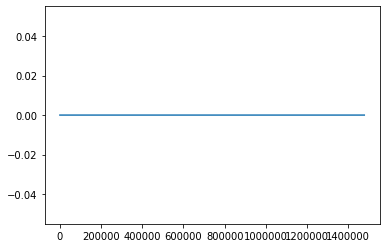

In [82]:
plt.plot(ieegdata[-1,:])

In [83]:
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "004"
session = "20200730"
#BIDS_save_495IA75_ON_ROTA_SELFP_R__2xLT_REF_STNR1-20200730T111628
task = "OnRotaSelfpR2xLTRefSTNR1"
run = "8"
fsample = dat["BIDS_struct_save"]["fsample"]
labels = list(dat["BIDS_struct_save"]["labels"])
ieegdata = dat["BIDS_struct_save"]["data"]
write_my_BIDS(ch_labels, fsample, ieegdata, subject_id, session, task, run, BIDS_path)

Creating RawArray with float64 data, n_channels=36, n_times=1477871
    Range : 0 ... 1477870 =      0.000 ...   360.808 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a
sub-003	n/a	n/a	n/a
sub-004	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "L

<ipython-input-11-4cbd850aeb68>:21: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)



Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\sub-004\ses-20200730\sub-004_ses-20200730_scans.tsv'...

filename	acq_time
ieeg/sub-004_ses-20200730_task-MED2xLTREFSTNR1_run-0_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-OFF2xLTLONG_run-1_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-ON2xLTRefSTNR1_run-1_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-ON2xLTRefSTNR1_run-2_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-ONRest2xLTRefSTNR1_run-3_ieeg.vhdr	n/a
Wrote C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\sub-004\ses-20200730\sub-004_ses-20200730_scans.tsv entry with ieeg\sub-004_ses-20200730_task-OnRotaSelfpR2xLTRefSTNR1_run-8_ieeg.vhdr.


### BIDS_save_495IA75_ON_SELFPACED_BLOCK_L_REF_STNR1-20200730T113026.DATA

In [84]:
dat = loadmat("sub004\\TMSI\\BIDS_save_495IA75_ON_SELFPACED_BLOCK_L_REF_STNR1-20200730T113026.DATA")
list(dat["BIDS_struct_save"]["labels"])

['CREF',
 'LFP_STNR1',
 'LFP_STNR2',
 'LFP_STNR3',
 'LFP_STNR4',
 'LFP_STNR5',
 'LFP_STNR6',
 'LFP_STNR7',
 'LFP_STNR8',
 'LFP_STNL1',
 'LFP_STNL2',
 'LFP_STNL3',
 'LFP_STNL4',
 'LFP_STNL5',
 'LFP_STNL6',
 'LFP_STNL7',
 'LFP_STNL8',
 'ECOG_L01',
 'ECOG_L02',
 'ECOG_L03',
 'ECOG_L04',
 'ECOG_L05',
 'ECOG_L06',
 'Cz',
 'Fz',
 'BIP 01',
 'BIP 02',
 'X',
 'Y',
 'Z',
 'AUX 2-1',
 'AUX 2-2',
 'AUX 2-3',
 'AUX 3-1',
 'AUX 3-2',
 'AUX 3-3']

In [85]:
ch_labels = ["CREF","LFP_BS_STN_R_1", "LFP_BS_STN_R_2", "LFP_BS_STN_R_3","LFP_BS_STN_R_4", "LFP_BS_STN_R_5",
             "LFP_BS_STN_R_6", "LFP_BS_STN_R_7", "LFP_BS_STN_R_8",
          "LFP_BS_STN_L_1", "LFP_BS_STN_L_2","LFP_BS_STN_L_3","LFP_BS_STN_L_4",
             "LFP_BS_STN_L_5", "LFP_BS_STN_L_6","LFP_BS_STN_L_7","LFP_BS_STN_L_8",
          "ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
          "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6",
          "EEG_TM_Cz", "EEG_TM_Fz","EMG_TM_BR_R_1", "EMG_TM_BR_L_1", "X", "Y", "Z",
          "AUX_2_1", "AUX_2_2", "AUX_2_3", "AUX_3_1", "AUX_3_2", "AUX_3_3"]

In [86]:
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "004"
session = "20200730"
task = "ONSelfpacedBlockLRefStnr1"
run = "9"
fsample = dat["BIDS_struct_save"]["fsample"]
labels = list(dat["BIDS_struct_save"]["labels"])
ieegdata = dat["BIDS_struct_save"]["data"]
write_my_BIDS(ch_labels, fsample, ieegdata, subject_id, session, task, run, BIDS_path)

Creating RawArray with float64 data, n_channels=36, n_times=1485221
    Range : 0 ... 1485220 =      0.000 ...   362.603 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a
sub-003	n/a	n/a	n/a
sub-004	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "L

<ipython-input-11-4cbd850aeb68>:21: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)



Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\sub-004\ses-20200730\sub-004_ses-20200730_scans.tsv'...

filename	acq_time
ieeg/sub-004_ses-20200730_task-MED2xLTREFSTNR1_run-0_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-OFF2xLTLONG_run-1_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-ON2xLTRefSTNR1_run-1_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-ON2xLTRefSTNR1_run-2_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-ONRest2xLTRefSTNR1_run-3_ieeg.vhdr	n/a
Wrote C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\sub-004\ses-20200730\sub-004_ses-20200730_scans.tsv entry with ieeg\sub-004_ses-20200730_task-ONSelfpacedBlockLRefStnr1_run-9_ieeg.vhdr.


### BIDS_save_495IA75_ON_SPEECH_2xLT_REF_STNR1-20200730T110115.DATA

In [87]:
dat = loadmat("sub004\\TMSI\\BIDS_save_495IA75_ON_SPEECH_2xLT_REF_STNR1-20200730T110115.DATA")
list(dat["BIDS_struct_save"]["labels"])

['CREF',
 'LFP_STNR1',
 'LFP_STNR2',
 'LFP_STNR3',
 'LFP_STNR4',
 'LFP_STNR5',
 'LFP_STNR6',
 'LFP_STNR7',
 'LFP_STNR8',
 'LFP_STNL1',
 'LFP_STNL2',
 'LFP_STNL3',
 'LFP_STNL4',
 'LFP_STNL5',
 'LFP_STNL6',
 'LFP_STNL7',
 'LFP_STNL8',
 'ECOG_L01',
 'ECOG_L02',
 'ECOG_L03',
 'ECOG_L04',
 'ECOG_L05',
 'ECOG_L06',
 'Cz',
 'Fz',
 'BIP 01',
 'BIP 02',
 'X',
 'Y',
 'Z',
 'AUX 2-1',
 'AUX 2-2',
 'AUX 2-3',
 'AUX 3-1',
 'AUX 3-2',
 'AUX 3-3']

In [88]:
ch_labels = ["CREF","LFP_BS_STN_R_1", "LFP_BS_STN_R_2", "LFP_BS_STN_R_3","LFP_BS_STN_R_4", "LFP_BS_STN_R_5",
             "LFP_BS_STN_R_6", "LFP_BS_STN_R_7", "LFP_BS_STN_R_8",
          "LFP_BS_STN_L_1", "LFP_BS_STN_L_2","LFP_BS_STN_L_3","LFP_BS_STN_L_4",
             "LFP_BS_STN_L_5", "LFP_BS_STN_L_6","LFP_BS_STN_L_7","LFP_BS_STN_L_8",
          "ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
          "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6",
          "EEG_TM_Cz", "EEG_TM_Fz","EMG_TM_BR_R_1", "EMG_TM_BR_L_1", "X", "Y", "Z",
          "AUX_2_1", "AUX_2_2", "AUX_2_3", "AUX_3_1", "AUX_3_2", "AUX_3_3"]

In [89]:
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "004"
session = "20200730"
task = "ONSpeech2xLTRefSTNR1"
run = "10"
fsample = dat["BIDS_struct_save"]["fsample"]
labels = list(dat["BIDS_struct_save"]["labels"])
ieegdata = dat["BIDS_struct_save"]["data"]
write_my_BIDS(ch_labels, fsample, ieegdata, subject_id, session, task, run, BIDS_path)

Creating RawArray with float64 data, n_channels=36, n_times=235196
    Range : 0 ... 235195 =      0.000 ...    57.421 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a
sub-003	n/a	n/a	n/a
sub-004	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "Lev

<ipython-input-11-4cbd850aeb68>:21: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)


### BIDS_save_495IA75_REST_OFF_REF_MASTOID-20200730T091815.DATA

In [90]:
dat = loadmat("sub004\\TMSI\\BIDS_save_495IA75_REST_OFF_REF_MASTOID-20200730T091815.DATA")
list(dat["BIDS_struct_save"]["labels"])

['CREF',
 'LFP_STNR1',
 'LFP_STNR2',
 'LFP_STNR3',
 'LFP_STNR4',
 'LFP_STNR5',
 'LFP_STNR6',
 'LFP_STNR7',
 'LFP_STNR8',
 'LFP_STNL1',
 'LFP_STNL2',
 'LFP_STNL3',
 'LFP_STNL4',
 'LFP_STNL5',
 'LFP_STNL6',
 'LFP_STNL7',
 'LFP_STNL8',
 'ECOG_L01',
 'ECOG_L02',
 'ECOG_L03',
 'ECOG_L04',
 'ECOG_L05',
 'ECOG_L06',
 'Cz',
 'Fz',
 'BIP 01',
 'BIP 02',
 'X',
 'Y',
 'Z',
 'AUX 2-1',
 'AUX 2-2',
 'AUX 2-3',
 'AUX 3-1',
 'AUX 3-2',
 'AUX 3-3']

In [91]:
ch_labels = ["CREF","LFP_BS_STN_R_1", "LFP_BS_STN_R_2", "LFP_BS_STN_R_3","LFP_BS_STN_R_4", "LFP_BS_STN_R_5",
             "LFP_BS_STN_R_6", "LFP_BS_STN_R_7", "LFP_BS_STN_R_8",
          "LFP_BS_STN_L_1", "LFP_BS_STN_L_2","LFP_BS_STN_L_3","LFP_BS_STN_L_4",
             "LFP_BS_STN_L_5", "LFP_BS_STN_L_6","LFP_BS_STN_L_7","LFP_BS_STN_L_8",
          "ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
          "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6",
          "EEG_TM_Cz", "EEG_TM_Fz","EMG_TM_BR_R_1", "EMG_TM_BR_L_1", "X", "Y", "Z",
          "AUX_2_1", "AUX_2_2", "AUX_2_3", "AUX_3_1", "AUX_3_2", "AUX_3_3"]

In [92]:
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "004"
session = "20200730"
task = "RestOffRefMastoid"
run = "11"
fsample = dat["BIDS_struct_save"]["fsample"]
labels = list(dat["BIDS_struct_save"]["labels"])
ieegdata = dat["BIDS_struct_save"]["data"]
write_my_BIDS(ch_labels, fsample, ieegdata, subject_id, session, task, run, BIDS_path)

Creating RawArray with float64 data, n_channels=36, n_times=770696
    Range : 0 ... 770695 =      0.000 ...   188.158 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a
sub-003	n/a	n/a	n/a
sub-004	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "Lev

<ipython-input-11-4cbd850aeb68>:21: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)



Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\sub-004\ses-20200730\sub-004_ses-20200730_scans.tsv'...

filename	acq_time
ieeg/sub-004_ses-20200730_task-MED2xLTREFSTNR1_run-0_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-OFF2xLTLONG_run-1_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-ON2xLTRefSTNR1_run-1_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-ON2xLTRefSTNR1_run-2_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-ONRest2xLTRefSTNR1_run-3_ieeg.vhdr	n/a
Wrote C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\sub-004\ses-20200730\sub-004_ses-20200730_scans.tsv entry with ieeg\sub-004_ses-20200730_task-RestOffRefMastoid_run-11_ieeg.vhdr.


### BIDS_save_495IA75_REST_OFF_REF_STNR1-20200730T092331.DATA

In [93]:
dat = loadmat("sub004\\TMSI\\BIDS_save_495IA75_REST_OFF_REF_STNR1-20200730T092331.DATA")
list(dat["BIDS_struct_save"]["labels"])

['CREF',
 'LFP_STNR1',
 'LFP_STNR2',
 'LFP_STNR3',
 'LFP_STNR4',
 'LFP_STNR5',
 'LFP_STNR6',
 'LFP_STNR7',
 'LFP_STNR8',
 'LFP_STNL1',
 'LFP_STNL2',
 'LFP_STNL3',
 'LFP_STNL4',
 'LFP_STNL5',
 'LFP_STNL6',
 'LFP_STNL7',
 'LFP_STNL8',
 'ECOG_L01',
 'ECOG_L02',
 'ECOG_L03',
 'ECOG_L04',
 'ECOG_L05',
 'ECOG_L06',
 'Cz',
 'Fz',
 'BIP 01',
 'BIP 02',
 'X',
 'Y',
 'Z',
 'AUX 2-1',
 'AUX 2-2',
 'AUX 2-3',
 'AUX 3-1',
 'AUX 3-2',
 'AUX 3-3']

In [94]:
ch_labels = ["CREF","LFP_BS_STN_R_1", "LFP_BS_STN_R_2", "LFP_BS_STN_R_3","LFP_BS_STN_R_4", "LFP_BS_STN_R_5",
             "LFP_BS_STN_R_6", "LFP_BS_STN_R_7", "LFP_BS_STN_R_8",
          "LFP_BS_STN_L_1", "LFP_BS_STN_L_2","LFP_BS_STN_L_3","LFP_BS_STN_L_4",
             "LFP_BS_STN_L_5", "LFP_BS_STN_L_6","LFP_BS_STN_L_7","LFP_BS_STN_L_8",
          "ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
          "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6",
          "EEG_TM_Cz", "EEG_TM_Fz","EMG_TM_BR_R_1", "EMG_TM_BR_L_1", "X", "Y", "Z",
          "AUX_2_1", "AUX_2_2", "AUX_2_3", "AUX_3_1", "AUX_3_2", "AUX_3_3"]

In [95]:
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "004"
session = "20200730"
task = "RestOffRefSTNR1"
run = "12"
fsample = dat["BIDS_struct_save"]["fsample"]
labels = list(dat["BIDS_struct_save"]["labels"])
ieegdata = dat["BIDS_struct_save"]["data"]
write_my_BIDS(ch_labels, fsample, ieegdata, subject_id, session, task, run, BIDS_path)

Creating RawArray with float64 data, n_channels=36, n_times=1254431
    Range : 0 ... 1254430 =      0.000 ...   306.257 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a
sub-003	n/a	n/a	n/a
sub-004	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "L

<ipython-input-11-4cbd850aeb68>:21: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)



Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\sub-004\ses-20200730\sub-004_ses-20200730_scans.tsv'...

filename	acq_time
ieeg/sub-004_ses-20200730_task-MED2xLTREFSTNR1_run-0_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-OFF2xLTLONG_run-1_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-ON2xLTRefSTNR1_run-1_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-ON2xLTRefSTNR1_run-2_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-ONRest2xLTRefSTNR1_run-3_ieeg.vhdr	n/a
Wrote C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\sub-004\ses-20200730\sub-004_ses-20200730_scans.tsv entry with ieeg\sub-004_ses-20200730_task-RestOffRefSTNR1_run-12_ieeg.vhdr.


### BIDS_save_495IA75_ROTA_BLOCK_OFF_LEFT_REF_STNR1-20200730T100047.DATA

In [96]:
dat = loadmat("sub004\\TMSI\\BIDS_save_495IA75_ROTA_BLOCK_OFF_LEFT_REF_STNR1-20200730T100047.DATA")
list(dat["BIDS_struct_save"]["labels"])

['CREF',
 'LFP_STNR1',
 'LFP_STNR2',
 'LFP_STNR3',
 'LFP_STNR4',
 'LFP_STNR5',
 'LFP_STNR6',
 'LFP_STNR7',
 'LFP_STNR8',
 'LFP_STNL1',
 'LFP_STNL2',
 'LFP_STNL3',
 'LFP_STNL4',
 'LFP_STNL5',
 'LFP_STNL6',
 'LFP_STNL7',
 'LFP_STNL8',
 'ECOG_L01',
 'ECOG_L02',
 'ECOG_L03',
 'ECOG_L04',
 'ECOG_L05',
 'ECOG_L06',
 'Cz',
 'Fz',
 'BIP 01',
 'BIP 02',
 'X',
 'Y',
 'Z',
 'AUX 2-1',
 'AUX 2-2',
 'AUX 2-3',
 'AUX 3-1',
 'AUX 3-2',
 'AUX 3-3']

In [97]:
ch_labels = ["CREF","LFP_BS_STN_R_1", "LFP_BS_STN_R_2", "LFP_BS_STN_R_3","LFP_BS_STN_R_4", "LFP_BS_STN_R_5",
             "LFP_BS_STN_R_6", "LFP_BS_STN_R_7", "LFP_BS_STN_R_8",
          "LFP_BS_STN_L_1", "LFP_BS_STN_L_2","LFP_BS_STN_L_3","LFP_BS_STN_L_4",
             "LFP_BS_STN_L_5", "LFP_BS_STN_L_6","LFP_BS_STN_L_7","LFP_BS_STN_L_8",
          "ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
          "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6",
          "EEG_TM_Cz", "EEG_TM_Fz","EMG_TM_BR_R_1", "EMG_TM_BR_L_1", "X", "Y", "Z",
          "AUX_2_1", "AUX_2_2", "AUX_2_3", "AUX_3_1", "AUX_3_2", "AUX_3_3"]

In [98]:
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "004"
session = "20200730"
task = "rotaBlockOffLeftRefSTNR1"
run = "13"
fsample = dat["BIDS_struct_save"]["fsample"]
labels = list(dat["BIDS_struct_save"]["labels"])
ieegdata = dat["BIDS_struct_save"]["data"]
write_my_BIDS(ch_labels, fsample, ieegdata, subject_id, session, task, run, BIDS_path)

Creating RawArray with float64 data, n_channels=36, n_times=1137566
    Range : 0 ... 1137565 =      0.000 ...   277.726 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a
sub-003	n/a	n/a	n/a
sub-004	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "L

<ipython-input-11-4cbd850aeb68>:21: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)



Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\sub-004\ses-20200730\sub-004_ses-20200730_scans.tsv'...

filename	acq_time
ieeg/sub-004_ses-20200730_task-MED2xLTREFSTNR1_run-0_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-OFF2xLTLONG_run-1_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-ON2xLTRefSTNR1_run-1_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-ON2xLTRefSTNR1_run-2_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-ONRest2xLTRefSTNR1_run-3_ieeg.vhdr	n/a
Wrote C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\sub-004\ses-20200730\sub-004_ses-20200730_scans.tsv entry with ieeg\sub-004_ses-20200730_task-rotaBlockOffLeftRefSTNR1_run-13_ieeg.vhdr.


### BIDS_save_495IA75_ROTA_BLOCK_OFF_REF_STNR1-20200730T094852.DATA

In [99]:
dat = loadmat("sub004\\TMSI\\BIDS_save_495IA75_ROTA_BLOCK_OFF_REF_STNR1-20200730T094852.DATA")
list(dat["BIDS_struct_save"]["labels"])

['CREF',
 'LFP_STNR1',
 'LFP_STNR2',
 'LFP_STNR3',
 'LFP_STNR4',
 'LFP_STNR5',
 'LFP_STNR6',
 'LFP_STNR7',
 'LFP_STNR8',
 'LFP_STNL1',
 'LFP_STNL2',
 'LFP_STNL3',
 'LFP_STNL4',
 'LFP_STNL5',
 'LFP_STNL6',
 'LFP_STNL7',
 'LFP_STNL8',
 'ECOG_L01',
 'ECOG_L02',
 'ECOG_L03',
 'ECOG_L04',
 'ECOG_L05',
 'ECOG_L06',
 'Cz',
 'Fz',
 'BIP 01',
 'BIP 02',
 'X',
 'Y',
 'Z',
 'AUX 2-1',
 'AUX 2-2',
 'AUX 2-3',
 'AUX 3-1',
 'AUX 3-2',
 'AUX 3-3']

In [100]:
ch_labels = ["CREF","LFP_BS_STN_R_1", "LFP_BS_STN_R_2", "LFP_BS_STN_R_3","LFP_BS_STN_R_4", "LFP_BS_STN_R_5",
             "LFP_BS_STN_R_6", "LFP_BS_STN_R_7", "LFP_BS_STN_R_8",
          "LFP_BS_STN_L_1", "LFP_BS_STN_L_2","LFP_BS_STN_L_3","LFP_BS_STN_L_4",
             "LFP_BS_STN_L_5", "LFP_BS_STN_L_6","LFP_BS_STN_L_7","LFP_BS_STN_L_8",
          "ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
          "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6",
          "EEG_TM_Cz", "EEG_TM_Fz","EMG_TM_BR_R_1", "EMG_TM_BR_L_1", "X", "Y", "Z",
          "AUX_2_1", "AUX_2_2", "AUX_2_3", "AUX_3_1", "AUX_3_2", "AUX_3_3"]

In [101]:
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "004"
session = "20200730"
task = "rotaBlockOffRefSTNR1"
run = "14"
fsample = dat["BIDS_struct_save"]["fsample"]
labels = list(dat["BIDS_struct_save"]["labels"])
ieegdata = dat["BIDS_struct_save"]["data"]
write_my_BIDS(ch_labels, fsample, ieegdata, subject_id, session, task, run, BIDS_path)

Creating RawArray with float64 data, n_channels=36, n_times=1151636
    Range : 0 ... 1151635 =      0.000 ...   281.161 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a
sub-003	n/a	n/a	n/a
sub-004	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "L

<ipython-input-11-4cbd850aeb68>:21: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)



Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\sub-004\ses-20200730\sub-004_ses-20200730_scans.tsv'...

filename	acq_time
ieeg/sub-004_ses-20200730_task-MED2xLTREFSTNR1_run-0_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-OFF2xLTLONG_run-1_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-ON2xLTRefSTNR1_run-1_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-ON2xLTRefSTNR1_run-2_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-ONRest2xLTRefSTNR1_run-3_ieeg.vhdr	n/a
Wrote C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\sub-004\ses-20200730\sub-004_ses-20200730_scans.tsv entry with ieeg\sub-004_ses-20200730_task-rotaBlockOffRefSTNR1_run-14_ieeg.vhdr.


### BIDS_save_495IA75_ROTA_SELFPACE_OFF_LEFT_REF_STNR1-20200730T095439.DATA

In [102]:
dat = loadmat("sub004\\TMSI\\BIDS_save_495IA75_ROTA_SELFPACE_OFF_LEFT_REF_STNR1-20200730T095439.DATA")
list(dat["BIDS_struct_save"]["labels"])

['CREF',
 'LFP_STNR1',
 'LFP_STNR2',
 'LFP_STNR3',
 'LFP_STNR4',
 'LFP_STNR5',
 'LFP_STNR6',
 'LFP_STNR7',
 'LFP_STNR8',
 'LFP_STNL1',
 'LFP_STNL2',
 'LFP_STNL3',
 'LFP_STNL4',
 'LFP_STNL5',
 'LFP_STNL6',
 'LFP_STNL7',
 'LFP_STNL8',
 'ECOG_L01',
 'ECOG_L02',
 'ECOG_L03',
 'ECOG_L04',
 'ECOG_L05',
 'ECOG_L06',
 'Cz',
 'Fz',
 'BIP 01',
 'BIP 02',
 'X',
 'Y',
 'Z',
 'AUX 2-1',
 'AUX 2-2',
 'AUX 2-3',
 'AUX 3-1',
 'AUX 3-2',
 'AUX 3-3']

In [103]:
ch_labels = ["CREF","LFP_BS_STN_R_1", "LFP_BS_STN_R_2", "LFP_BS_STN_R_3","LFP_BS_STN_R_4", "LFP_BS_STN_R_5",
             "LFP_BS_STN_R_6", "LFP_BS_STN_R_7", "LFP_BS_STN_R_8",
          "LFP_BS_STN_L_1", "LFP_BS_STN_L_2","LFP_BS_STN_L_3","LFP_BS_STN_L_4",
             "LFP_BS_STN_L_5", "LFP_BS_STN_L_6","LFP_BS_STN_L_7","LFP_BS_STN_L_8",
          "ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
          "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6",
          "EEG_TM_Cz", "EEG_TM_Fz","EMG_TM_BR_R_1", "EMG_TM_BR_L_1", "X", "Y", "Z",
          "AUX_2_1", "AUX_2_2", "AUX_2_3", "AUX_3_1", "AUX_3_2", "AUX_3_3"]

In [104]:
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "004"
session = "20200730"
task = "RotaSelfpaceOFFLeftRefSTNR1"
run = "15"
fsample = dat["BIDS_struct_save"]["fsample"]
labels = list(dat["BIDS_struct_save"]["labels"])
ieegdata = dat["BIDS_struct_save"]["data"]
write_my_BIDS(ch_labels, fsample, ieegdata, subject_id, session, task, run, BIDS_path)

Creating RawArray with float64 data, n_channels=36, n_times=1449521
    Range : 0 ... 1449520 =      0.000 ...   353.887 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a
sub-003	n/a	n/a	n/a
sub-004	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "L

<ipython-input-11-4cbd850aeb68>:21: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)



Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\sub-004\ses-20200730\sub-004_ses-20200730_scans.tsv'...

filename	acq_time
ieeg/sub-004_ses-20200730_task-MED2xLTREFSTNR1_run-0_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-OFF2xLTLONG_run-1_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-ON2xLTRefSTNR1_run-1_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-ON2xLTRefSTNR1_run-2_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-ONRest2xLTRefSTNR1_run-3_ieeg.vhdr	n/a
Wrote C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\sub-004\ses-20200730\sub-004_ses-20200730_scans.tsv entry with ieeg\sub-004_ses-20200730_task-RotaSelfpaceOFFLeftRefSTNR1_run-15_ieeg.vhdr.


### BIDS_save_495IA75_ROTA_SELFPACED_OFF_REF_STNR1-20200730T093752.DATA

In [105]:
dat = loadmat("sub004\\TMSI\\BIDS_save_495IA75_ROTA_SELFPACED_OFF_REF_STNR1-20200730T093752.DATA")
list(dat["BIDS_struct_save"]["labels"])

['CREF',
 'LFP_STNR1',
 'LFP_STNR2',
 'LFP_STNR3',
 'LFP_STNR4',
 'LFP_STNR5',
 'LFP_STNR6',
 'LFP_STNR7',
 'LFP_STNR8',
 'LFP_STNL1',
 'LFP_STNL2',
 'LFP_STNL3',
 'LFP_STNL4',
 'LFP_STNL5',
 'LFP_STNL6',
 'LFP_STNL7',
 'LFP_STNL8',
 'ECOG_L01',
 'ECOG_L02',
 'ECOG_L03',
 'ECOG_L04',
 'ECOG_L05',
 'ECOG_L06',
 'Cz',
 'Fz',
 'BIP 01',
 'BIP 02',
 'X',
 'Y',
 'Z',
 'AUX 2-1',
 'AUX 2-2',
 'AUX 2-3',
 'AUX 3-1',
 'AUX 3-2',
 'AUX 3-3']

In [106]:
ch_labels = ["CREF","LFP_BS_STN_R_1", "LFP_BS_STN_R_2", "LFP_BS_STN_R_3","LFP_BS_STN_R_4", "LFP_BS_STN_R_5",
             "LFP_BS_STN_R_6", "LFP_BS_STN_R_7", "LFP_BS_STN_R_8",
          "LFP_BS_STN_L_1", "LFP_BS_STN_L_2","LFP_BS_STN_L_3","LFP_BS_STN_L_4",
             "LFP_BS_STN_L_5", "LFP_BS_STN_L_6","LFP_BS_STN_L_7","LFP_BS_STN_L_8",
          "ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
          "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6",
          "EEG_TM_Cz", "EEG_TM_Fz","EMG_TM_BR_R_1", "EMG_TM_BR_L_1", "X", "Y", "Z",
          "AUX_2_1", "AUX_2_2", "AUX_2_3", "AUX_3_1", "AUX_3_2", "AUX_3_3"]

In [107]:
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "004"
session = "20200730"
task = "RotaSelfpaceOFFRefSTNR1"
run = "16"
fsample = dat["BIDS_struct_save"]["fsample"]
labels = list(dat["BIDS_struct_save"]["labels"])
ieegdata = dat["BIDS_struct_save"]["data"]
write_my_BIDS(ch_labels, fsample, ieegdata, subject_id, session, task, run, BIDS_path)

Creating RawArray with float64 data, n_channels=36, n_times=2103146
    Range : 0 ... 2103145 =      0.000 ...   513.463 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a
sub-003	n/a	n/a	n/a
sub-004	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "L

<ipython-input-11-4cbd850aeb68>:21: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)



Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\sub-004\ses-20200730\sub-004_ses-20200730_scans.tsv'...

filename	acq_time
ieeg/sub-004_ses-20200730_task-MED2xLTREFSTNR1_run-0_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-OFF2xLTLONG_run-1_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-ON2xLTRefSTNR1_run-1_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-ON2xLTRefSTNR1_run-2_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-ONRest2xLTRefSTNR1_run-3_ieeg.vhdr	n/a
Wrote C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\sub-004\ses-20200730\sub-004_ses-20200730_scans.tsv entry with ieeg\sub-004_ses-20200730_task-RotaSelfpaceOFFRefSTNR1_run-16_ieeg.vhdr.


### BIDS_save_495IA75_SPEECH_REF_STNR1-20200730T101644.DATA

In [108]:
dat = loadmat("sub004\\TMSI\\BIDS_save_495IA75_SPEECH_REF_STNR1-20200730T101644.DATA")
list(dat["BIDS_struct_save"]["labels"])

['CREF',
 'LFP_STNR1',
 'LFP_STNR2',
 'LFP_STNR3',
 'LFP_STNR4',
 'LFP_STNR5',
 'LFP_STNR6',
 'LFP_STNR7',
 'LFP_STNR8',
 'LFP_STNL1',
 'LFP_STNL2',
 'LFP_STNL3',
 'LFP_STNL4',
 'LFP_STNL5',
 'LFP_STNL6',
 'LFP_STNL7',
 'LFP_STNL8',
 'ECOG_L01',
 'ECOG_L02',
 'ECOG_L03',
 'ECOG_L04',
 'ECOG_L05',
 'ECOG_L06',
 'Cz',
 'Fz',
 'BIP 01',
 'BIP 02',
 'X',
 'Y',
 'Z',
 'AUX 2-1',
 'AUX 2-2',
 'AUX 2-3',
 'AUX 3-1',
 'AUX 3-2',
 'AUX 3-3']

In [109]:
ch_labels = ["CREF","LFP_BS_STN_R_1", "LFP_BS_STN_R_2", "LFP_BS_STN_R_3","LFP_BS_STN_R_4", "LFP_BS_STN_R_5",
             "LFP_BS_STN_R_6", "LFP_BS_STN_R_7", "LFP_BS_STN_R_8",
          "LFP_BS_STN_L_1", "LFP_BS_STN_L_2","LFP_BS_STN_L_3","LFP_BS_STN_L_4",
             "LFP_BS_STN_L_5", "LFP_BS_STN_L_6","LFP_BS_STN_L_7","LFP_BS_STN_L_8",
          "ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
          "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6",
          "EEG_TM_Cz", "EEG_TM_Fz","EMG_TM_BR_R_1", "EMG_TM_BR_L_1", "X", "Y", "Z",
          "AUX_2_1", "AUX_2_2", "AUX_2_3", "AUX_3_1", "AUX_3_2", "AUX_3_3"]

In [110]:
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "004"
session = "20200730"
task = "SpeechRefSTNR1"
run = "17"
fsample = dat["BIDS_struct_save"]["fsample"]
labels = list(dat["BIDS_struct_save"]["labels"])
ieegdata = dat["BIDS_struct_save"]["data"]
write_my_BIDS(ch_labels, fsample, ieegdata, subject_id, session, task, run, BIDS_path)

Creating RawArray with float64 data, n_channels=36, n_times=346496
    Range : 0 ... 346495 =      0.000 ...    84.594 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a
sub-003	n/a	n/a	n/a
sub-004	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "Lev

<ipython-input-11-4cbd850aeb68>:21: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)


### BIDS_save_495IA75_UPDRS-III_OFF_REF_STNR1-20200730T101100.DATA

In [111]:
dat = loadmat("sub004\\TMSI\\BIDS_save_495IA75_UPDRS-III_OFF_REF_STNR1-20200730T101100.DATA")
list(dat["BIDS_struct_save"]["labels"])

['CREF',
 'LFP_STNR1',
 'LFP_STNR2',
 'LFP_STNR3',
 'LFP_STNR4',
 'LFP_STNR5',
 'LFP_STNR6',
 'LFP_STNR7',
 'LFP_STNR8',
 'LFP_STNL1',
 'LFP_STNL2',
 'LFP_STNL3',
 'LFP_STNL4',
 'LFP_STNL5',
 'LFP_STNL6',
 'LFP_STNL7',
 'LFP_STNL8',
 'ECOG_L01',
 'ECOG_L02',
 'ECOG_L03',
 'ECOG_L04',
 'ECOG_L05',
 'ECOG_L06',
 'Cz',
 'Fz',
 'BIP 01',
 'BIP 02',
 'X',
 'Y',
 'Z',
 'AUX 2-1',
 'AUX 2-2',
 'AUX 2-3',
 'AUX 3-1',
 'AUX 3-2',
 'AUX 3-3']

In [112]:
ch_labels = ["CREF","LFP_BS_STN_R_1", "LFP_BS_STN_R_2", "LFP_BS_STN_R_3","LFP_BS_STN_R_4", "LFP_BS_STN_R_5",
             "LFP_BS_STN_R_6", "LFP_BS_STN_R_7", "LFP_BS_STN_R_8",
          "LFP_BS_STN_L_1", "LFP_BS_STN_L_2","LFP_BS_STN_L_3","LFP_BS_STN_L_4",
             "LFP_BS_STN_L_5", "LFP_BS_STN_L_6","LFP_BS_STN_L_7","LFP_BS_STN_L_8",
          "ECOG_AT_SM_L_1", "ECOG_AT_SM_L_2", 
          "ECOG_AT_SM_L_3", "ECOG_AT_SM_L_4", "ECOG_AT_SM_L_5", "ECOG_AT_SM_L_6",
          "EEG_TM_Cz", "EEG_TM_Fz","EMG_TM_BR_R_1", "EMG_TM_BR_L_1", "X", "Y", "Z",
          "AUX_2_1", "AUX_2_2", "AUX_2_3", "AUX_3_1", "AUX_3_2", "AUX_3_3"]

In [113]:
BIDS_path = "C:\\Users\\ICN_admin\\Documents\\WRITE_BERLIN_BIDS\\BIDS_Berlin\\"
subject_id = "004"
session = "20200730"
task = "UPDRSIIIOffRefSTNR1"
run = "18"
fsample = dat["BIDS_struct_save"]["fsample"]
labels = list(dat["BIDS_struct_save"]["labels"])
ieegdata = dat["BIDS_struct_save"]["data"]
write_my_BIDS(ch_labels, fsample, ieegdata, subject_id, session, task, run, BIDS_path)

Creating RawArray with float64 data, n_channels=36, n_times=1005791
    Range : 0 ... 1005790 =      0.000 ...   245.554 secs
Ready.
ECoG channel type selected for re-referencing
EEG data marked as already having the desired reference.
Extracting parameters from dummy_write.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\dummy_write.vhdr...
Setting channel info structure...

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.tsv'...

participant_id	age	sex	hand
sub-002	n/a	n/a	n/a
sub-003	n/a	n/a	n/a
sub-004	n/a	n/a	n/a

Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "L

<ipython-input-11-4cbd850aeb68>:21: RuntimeWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  mne_bids.write_raw_bids(bv_raw, bids_path=bids_basename, overwrite=True)



Writing 'C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\sub-004\ses-20200730\sub-004_ses-20200730_scans.tsv'...

filename	acq_time
ieeg/sub-004_ses-20200730_task-MED2xLTREFSTNR1_run-0_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-OFF2xLTLONG_run-1_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-ON2xLTRefSTNR1_run-1_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-ON2xLTRefSTNR1_run-2_ieeg.vhdr	n/a
ieeg/sub-004_ses-20200730_task-ONRest2xLTRefSTNR1_run-3_ieeg.vhdr	n/a
Wrote C:\Users\ICN_admin\Documents\WRITE_BERLIN_BIDS\BIDS_Berlin\sub-004\ses-20200730\sub-004_ses-20200730_scans.tsv entry with ieeg\sub-004_ses-20200730_task-UPDRSIIIOffRefSTNR1_run-18_ieeg.vhdr.
